In [1]:
!pip install -q -U tensorflow-text==2.7.3

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 495.0 MB 28 kB/s 
     |████████████████████████████████| 463 kB 36.5 MB/s 
     |████████████████████████████████| 1.3 MB 40.8 MB/s 


In [2]:
!pip install -q -U tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.5 MB/s 
     |████████████████████████████████| 99 kB 7.3 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 43.9 MB/s 
     |████████████████████████████████| 352 kB 56.8 MB/s 
     |████████████████████████████████| 234 kB 37.4 MB/s 
     |████████████████████████████████| 90 kB 8.4 MB/s 
     |████████████████████████████████| 1.1 MB 46.5 MB/s 
     |████████████████████████████████| 47.7 MB 2.0 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 


In [3]:
!pip install -U tfds-nightly==4.3.0.dev202107180106

     |████████████████████████████████| 4.0 MB 5.3 MB/s 


In [4]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [5]:
print(tf.__version__)

2.7.1


In [6]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [7]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU. Will take too much time.')

Using TPU


In [8]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [9]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [10]:
test_preprocess_model = make_bert_preprocess_model(['input_1', 'input_2'])
test_text = [np.array(['Dr. Dhirendra Kumar Sharma is a professor at UPES']),
             np.array(['Dr. Chandan Sharma is also a professor at UPES'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_mask', 'input_type_ids', 'input_word_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  2852  1012 28144  7442 17670  9600 14654  2003  1037  2934  2012
  2039  2229   102  2852], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(16,), dtype=int32)


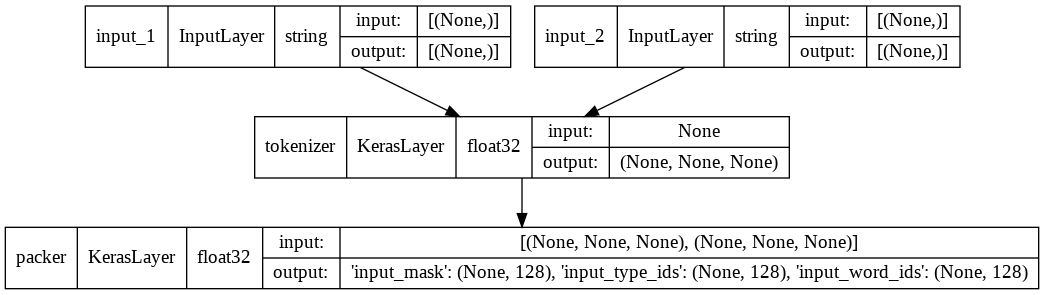

In [11]:
tf.keras.utils.plot_model(test_preprocess_model, show_shapes=True, show_dtype=True)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE


def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

## Defining the model

In [13]:
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

testing the model on preprocessed inputs.

In [14]:
test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.50946224 0.25630397]], shape=(1, 2), dtype=float32)


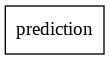

In [15]:
tf.keras.utils.plot_model(test_classifier_model, show_shapes=True, show_dtype=True)

## Choose a task from GLUE


In [16]:
tfds_name = 'glue/mrpc'

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(10):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/mrpc from TFDS
This dataset has 5801 examples
Number of classes: 2
Features ['sentence1', 'sentence2']
Splits ['train', 'validation', 'test']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3668 [00:00<?, ? examples/s]

Shuffling glue-train.tfrecord...:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/408 [00:00<?, ? examples/s]

Shuffling glue-validation.tfrecord...:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1725 [00:00<?, ? examples/s]

Shuffling glue-test.tfrecord...:   0%|          | 0/1725 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/2.0.0. Subsequent calls will reuse this data.
Here are some sample rows from glue/mrpc dataset
['not_equivalent', 'equivalent']

sample row 1
b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
b'The rovers act as robotic geologists , moving on six wheels .'
label: 0 (not_equivalent)

sample row 2
b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed ."
b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is complete , assuming those businesses aren 't sold ."
label: 0 (not_equivalent)

sample row 3
b'Spider-Man snatched $ 114.7 million in its debut last year and went on to capture $ 403.7 million .'
b'Spider-Man , rated PG-13 , snatched $ 114.7 million in its first weekend and went on to take in $ 403.7 million .'
label: 1 (equivalent)

sample

The dataset also determines the problem type (classification or regression) and the appropriate loss function for training.

In [17]:
def get_configuration(glue_task):

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#   metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
  metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)


  return metrics, loss

## Train your model

In [18]:
epochs = 3
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():

  # metric have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)

  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  history = classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


114/114 [==============================] - 87s 145ms/step - loss: 0.6092 - accuracy: 0.6990 - val_loss: 0.4922 - val_accuracy: 0.7708
Epoch 2/3
114/114 [==============================] - 10s 86ms/step - loss: 0.4316 - accuracy: 0.8155 - val_loss: 0.4347 - val_accuracy: 0.8125
Epoch 3/3
114/114 [==============================] - 10s 86ms/step - loss: 0.2769 - accuracy: 0.8925 - val_loss: 0.4717 - val_accuracy: 0.8307


In [19]:
test_dataset, test_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, test_split, batch_size, bert_preprocess_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [20]:
history.history

{'accuracy': [0.6990131735801697, 0.8155153393745422, 0.8925438523292542],
 'loss': [0.6091907620429993, 0.43160945177078247, 0.27687516808509827],
 'val_accuracy': [0.7708333730697632, 0.8125, 0.8307291865348816],
 'val_loss': [0.49219363927841187, 0.43472325801849365, 0.4717487692832947]}

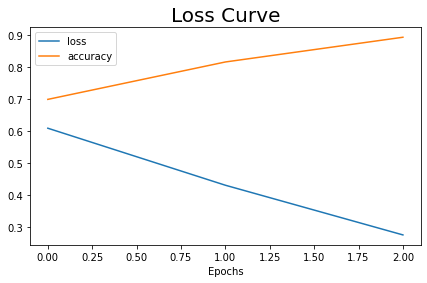

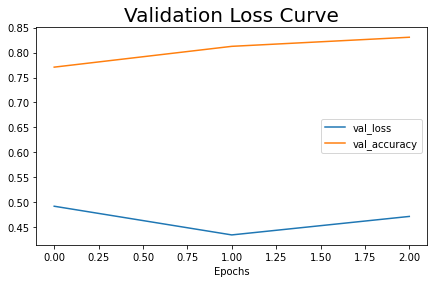

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(history.history)

# Creating a plot for loss and accuracy
plt.figure(figsize=(7,4))
plt.plot(df['loss'])
plt.plot(df['accuracy'])
plt.legend(['loss', 'accuracy'])
plt.title("Loss Curve", fontdict={'fontsize':20})
plt.xlabel("Epochs")
plt.show();

# Creating a plot for validation loss and validation accuracy
plt.figure(figsize=(7,4))
plt.plot(df['val_loss'])
plt.plot(df['val_accuracy'])
plt.legend(['val_loss', 'val_accuracy'])
plt.title("Validation Loss Curve", fontdict={'fontsize':20})
plt.xlabel("Epochs")
plt.show();

## Export for inference


In [22]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Saving ./my_models/glue_mrpc_bert_en_uncased_L-12_H-768_A-12


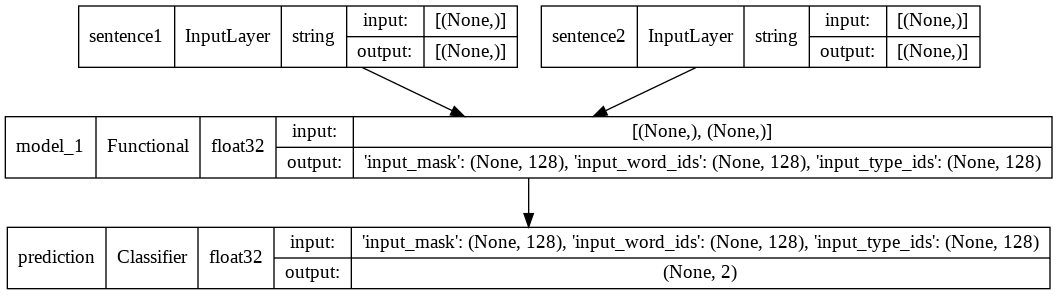

In [23]:
tf.keras.utils.plot_model(model_for_export, show_shapes=True, show_dtype=True)

In [24]:
classifier_model.evaluate(test_dataset)

54/54 [==============================] - 4s 28ms/step - loss: nan - accuracy: 0.0000e+00


[nan, 0.0]

In [25]:
pred = classifier_model.predict(test_dataset)

In [26]:
pred

array([[-1.8904157,  1.8796599],
       [-2.318752 ,  2.9454317],
       [-2.089592 ,  2.9221418],
       ...,
       [-2.4008143,  3.3196504],
       [-2.0248687,  2.3389583],
       [-2.2115967,  2.4405775]], dtype=float32)

## Test the model


In [27]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)

In [31]:
# Utility methods

def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  return model_inputs


def prepare_serving(record):
  model_inputs = {ft: record[ft] for ft in sentence_features}
  return model_inputs


def print_bert_results(test, bert_result, dataset_name):

  bert_result_class = tf.argmax(bert_result, axis=1)[0]

  print('sentence1:', test[0])
  print('sentence2:', test[1])
  if bert_result_class == 1:
    print('Are a paraphrase')
  else:
    print('Are NOT a paraphrase')



  print('BERT raw results:', bert_result[0])
  print()

### Test

In [29]:
def load_dataset_from_tfds_2(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):

  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  dataset = dataset.batch(batch_size)
  
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

v_dataset, v_data_size = load_dataset_from_tfds_2(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)

In [30]:
v_dataset_2 = v_dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [60]:
ar = []
pr = []

with tf.device('/job:localhost'):

    test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[validation_split])
    for test_row in test_dataset:
        ar.append(test_row['label'].numpy())
        pr.append(tf.argmax(reloaded_model([tf.reshape(test_row['sentence1'], (1,)), tf.reshape(test_row['sentence2'], (1,))]), axis=1)[0].numpy())

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ar, pr)

array([[ 80,  49],
       [ 21, 258]])

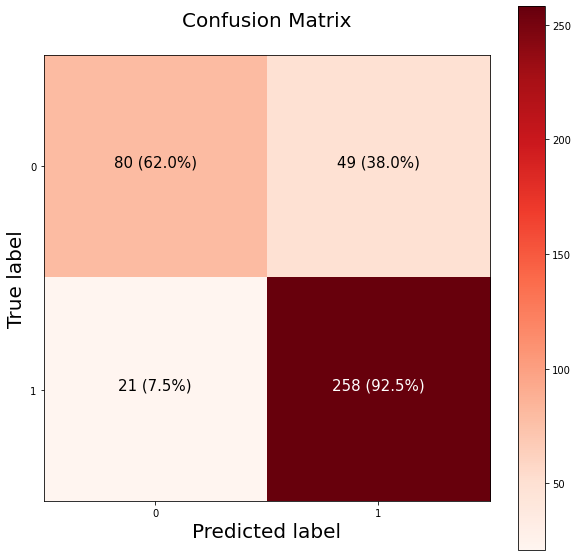

In [62]:
from sklearn.metrics import confusion_matrix
import itertools


figsize = (10, 10)
# Create the confusion matrix
cm = confusion_matrix(ar, pr)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Reds)
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)


In [64]:
with tf.device('/job:localhost'):

    false_pred = []

    test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[validation_split])
    i = 0
    for test_row in test_dataset:
        if ar[i] != pr[i]:
            false_pred.append({'id': i,
                               'actual_label': ar[i],
                               'predicted_label': pr[i],
                               'sentence1': test_row['sentence1'].numpy(),
                               'sentence2': test_row['sentence2'].numpy()})
        i = i+1

In [65]:
for fp in false_pred:
    if fp['actual_label']==0:  # False negative
        print()
        print(fp['sentence1'])
        print(fp['sentence2'])
        print()


b'About two hours later , his body , wrapped in a blanket , was found dumped a few blocks away .'
b'Then his body was dumped a few blocks away , found in a driveway on Argyle Road .'


b'The other inmate fell but Selenski shimmed down the makeshift rope to a second-story roof and used the mattress to scale a razor-wire fence , Fischi said .'
b'After the other inmate fell , Selenski used the mattress to scale a 10-foot , razor-wire fence , Fischi said .'


b'Bob Richter , a spokesman for House Speaker Tom Craddick , had no comment about the ruling .'
b'Bob Richter , spokesman for Craddick , R-Midland , said the speaker had not seen the ruling and could not comment .'


b'But late Thursday night , the campaign issued a statement saying there would be no news conference and no big announcement .'
b'But late yesterday , the campaign and the state Democratic Party said there would be no news conference .'


b'" Biotech products , if anything , may be safer than conventional products becaus

On random data (without labels)

In [68]:
with tf.device('/job:localhost'):
  test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
  for test_row in test_dataset.shuffle(1000).map(prepare).take(10):
    result = reloaded_model(list(test_row))

    print_bert_results(test_row, result, tfds_name)

sentence1: tf.Tensor([b'Telemarketers who call numbers on the list after Oct. 1 could face fines of up to $ 11,000 per call .'], shape=(1,), dtype=string)
sentence2: tf.Tensor([b'Under the law , telemarketers who call numbers on the list can be fined up to $ 11,000 for each violation .'], shape=(1,), dtype=string)
Are NOT a paraphrase
BERT raw results: tf.Tensor([ 0.2798406  -0.07493602], shape=(2,), dtype=float32)

sentence1: tf.Tensor([b'Police said they arrested a man on suspicion of burglary , which covers unauthorized entry .'], shape=(1,), dtype=string)
sentence2: tf.Tensor([b'Mr Barschak was arrested on suspicion of burglary , which covers unauthorised entry .'], shape=(1,), dtype=string)
Are a paraphrase
BERT raw results: tf.Tensor([-1.5056486  2.1421144], shape=(2,), dtype=float32)

sentence1: tf.Tensor([b'His family and friends said he had travelled to the region for a cultural visit .'], shape=(1,), dtype=string)
sentence2: tf.Tensor([b'Family and friends of the west Belfast

In [67]:
with tf.device('/job:localhost'):
  serving_model = reloaded_model.signatures['serving_default']
  for test_row in test_dataset.shuffle(1000).map(prepare_serving).take(10):
    result = serving_model(**test_row)
    # The 'prediction' key is the classifier's defined model name.
    print_bert_results(list(test_row.values()), result['prediction'], tfds_name)

sentence1: tf.Tensor(b'Sobig.F spreads when unsuspecting computer users open file attachments in emails that contain such familiar headings as " Thank You ! , " " Re : Details " or " Re : That Movie . "', shape=(), dtype=string)
sentence2: tf.Tensor(b'The virus spreads when unsuspecting computer users open file attachments in emails that contain familiar headings like " Thank You ! " and " Re : Details " .', shape=(), dtype=string)
Are a paraphrase
BERT raw results: tf.Tensor([-1.6159996  2.7439551], shape=(2,), dtype=float32)

sentence1: tf.Tensor(b'That compared with a year-earlier profit of $ 102 million , or 13 cents a share .', shape=(), dtype=string)
sentence2: tf.Tensor(b'That was more than double the $ 102 million , or 13 cents a share , for the year-earlier quarter .', shape=(), dtype=string)
Are a paraphrase
BERT raw results: tf.Tensor([-0.5912405   0.06325997], shape=(2,), dtype=float32)

sentence1: tf.Tensor(b'Staff Sgt. Georg-Andreas Pogany , however , is waiting for that 

Saved model could be used for serving or simple inference in a process, with a simpler api with less code and easier to maintain.
